# Pair-Wise Distance Analysis

## Preliminaries

In [65]:
%matplotlib inline
from os import path
from scipy.spatial.distance import pdist
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import seaborn as sns
import sys

sys.path.append(path.join("..", "..", "src", "speech_dtw", "utils"))

import analyse_pairs
import dp_align
import samediff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [126]:
# Language and hash codes
language = "SP"
cae_utd_hash = "3507b1dee4"
cae_gt_hash = "97d5e64521"

language = "HA"
cae_utd_hash = "5addd62282"
cae_gt_hash = "2962460ef0"

language = "CH"
cae_utd_hash = "0af93a3cdf"
cae_gt_hash = "8c7b5494d9"

language = "SW"
cae_utd_hash = "d0e6bc9e00"
cae_gt_hash = "9dc86566ea"

multiling_hash = "1482d0caf3"

In [127]:
# Embedding filenames
downsample_fn = path.join("..", "downsample", "exp", language, "mfcc.dev.filter1_gt.downsample_10.npz") 
cae_utd_fn = path.join("..", "embeddings", "models", language + ".utd", "train_cae_rnn", cae_utd_hash, "cae.best_val." + language.lower() + ".dev.filter1_gt.npz")
cae_gt_fn = path.join("..", "embeddings", "models", language + ".gt", "train_cae_rnn", cae_gt_hash, "cae.best_val." + language.lower() + ".dev.filter1_gt.npz")
multiling_fn = path.join("..", "embeddings", "models", "RU+CZ+FR+PL+TH+PO.gt", "train_cae_rnn", multiling_hash, "cae.best_val." + language.lower() + ".dev.filter1_gt.npz")

In [128]:
# Embeddings
embeddings = {}  # embeddings["downsample"] gives the embeddings of a method
embeddings["downsample"] = np.load(downsample_fn)
embeddings["cae_utd"] = np.load(cae_utd_fn)
embeddings["cae_gt"] = np.load(cae_gt_fn)
embeddings["multiling"] = np.load(multiling_fn)

In [129]:
# Models
models = ["downsample", "cae_utd", "cae_gt", "multiling"]
model_titles = ["Downsample", "CAE-RNN (UTD)", "CAE-RNN (GT)", "CAE-RNN (multiling.)"]

## Distances

In [130]:
def process_embeddings(embeddings):
    print("Ordering embeddings:")
    n_embeds = 0
    X = []
    utt_keys = []
    labels = []
    speakers = []
    for utt_key in tqdm(sorted(embeddings)):
        utt_keys.append(utt_key)
        X.append(embeddings[utt_key])
        utt_key = utt_key.split("_")
        label = utt_key[0]
        speaker = utt_key[1]
        labels.append(label)
        speakers.append(speaker)
    X = np.array(X)
    print("No. embeddings:", X.shape[0])
    print("Embedding dimensionality:", X.shape[1])

    # Normalise
    normed = (X - X.mean(axis=0)) / X.std(axis=0)
    X = normed

    print("Calculating distances")
    distances = pdist(X, metric="cosine")

    return (utt_keys, labels, speakers, distances)

In [131]:
distances = {}
for model in ["downsample", "cae_utd", "cae_gt", "multiling"]:
    print("Model:", model)
    (cur_utt_keys, cur_labels, cur_speakers, cur_distances) = process_embeddings(embeddings[model])
    distances[model] = cur_distances
utt_keys = cur_utt_keys
labels = cur_labels
speakers = cur_speakers

print("Calculating word matches")
word_matches = samediff.generate_matches_array(labels)
print("Total no. pairs:", word_matches.shape[0])
print("No. same-word pairs:", sum(word_matches))
print("Calculating speaker matches")
speaker_matches = samediff.generate_matches_array(speakers)
print("No. same-speaker pairs:", sum(speaker_matches))    

  0%|          | 11/3917 [00:00<00:35, 109.83it/s]

Model: downsample
Ordering embeddings:


100%|██████████| 3917/3917 [00:04<00:00, 822.74it/s] 


No. embeddings: 3917
Embedding dimensionality: 130
Calculating distances


  1%|          | 25/3917 [00:00<00:18, 210.73it/s]

Model: cae_utd
Ordering embeddings:


100%|██████████| 3917/3917 [00:02<00:00, 1375.35it/s]


No. embeddings: 3917
Embedding dimensionality: 130
Calculating distances


  0%|          | 16/3917 [00:00<00:24, 158.92it/s]

Model: cae_gt
Ordering embeddings:


100%|██████████| 3917/3917 [00:02<00:00, 1350.04it/s]


No. embeddings: 3917
Embedding dimensionality: 130
Calculating distances


  1%|          | 23/3917 [00:00<00:17, 223.76it/s]

Model: multiling
Ordering embeddings:


100%|██████████| 3917/3917 [00:03<00:00, 1255.72it/s]


No. embeddings: 3917
Embedding dimensionality: 130
Calculating distances
Calculating word matches
Total no. pairs: 7669486
No. same-word pairs: 39447
Calculating speaker matches
No. same-speaker pairs: 874270


## Word type

In [86]:
# Distances
pos = {}
neg = {}
for model in models:
    # Distances
    cur_pos = distances[model][word_matches == True]
    cur_neg = distances[model][word_matches == False]
    pos[model] = cur_pos
    neg[model] = cur_neg

In [87]:
# Dataframe
data_same_word = []
data_diff_word = []
for model in models:
    data_same_word += [[model, d, "same"] for d in pos[model]]
    data_diff_word += [[model, d, "different"] for d in neg[model]]
df_word = pd.DataFrame(data_diff_word + data_same_word, columns=["model", "distance", "match"])
del data_same_word
del data_diff_word

In [88]:
df_word

,model,distance,match
0,downsample,0.815428,different
1,downsample,0.588599,different
2,downsample,0.654075,different
3,downsample,0.719686,different
4,downsample,0.671847,different
5,downsample,0.707208,different
6,downsample,0.678819,different
7,downsample,0.844352,different
8,downsample,0.746811,different
9,downsample,0.718215,different


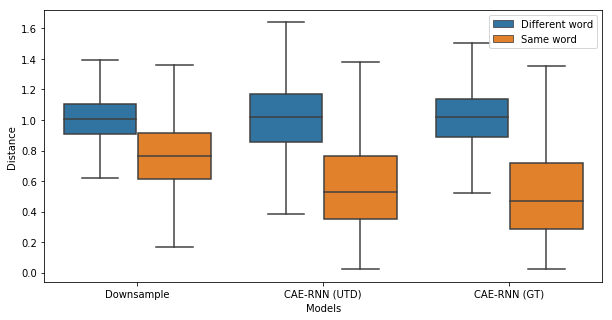

In [91]:
# Box plot
fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax = sns.boxplot(ax=ax, x="model", y="distance", hue="match", data=df_word, order=models[:-1], showfliers=False)
handles, lables = ax.get_legend_handles_labels()
ax.legend(handles, ["Different word", "Same word"], loc="upper right")
ax.set_xticklabels(model_titles[:-1])
plt.xlabel("Models")
plt.ylabel("Distance")
plt.savefig(path.join("doc", language.lower() + ".word_boxplot.pdf"))

## Speaker identity

In [132]:
# Distances
pos = {}
neg = {}
for model in models:
    cur_pos = distances[model][np.logical_and(word_matches, speaker_matches)]
    cur_neg = distances[model][np.logical_and(word_matches, speaker_matches == False)]
    pos[model] = cur_pos
    neg[model] = cur_neg
print("No. positive distances:", len(cur_pos))
print("No. negative distances:", len(cur_neg))
    
# Dataframe
data_same_speaker = []
data_diff_speaker = []
for model in models:
    data_same_speaker += [[model, d, "same"] for d in pos[model]]
    data_diff_speaker += [[model, d, "different"] for d in neg[model]]
df_speaker = pd.DataFrame(data_same_speaker + data_diff_speaker, columns=["model", "distance", "match"])

No. positive distances: 6218
No. negative distances: 33229


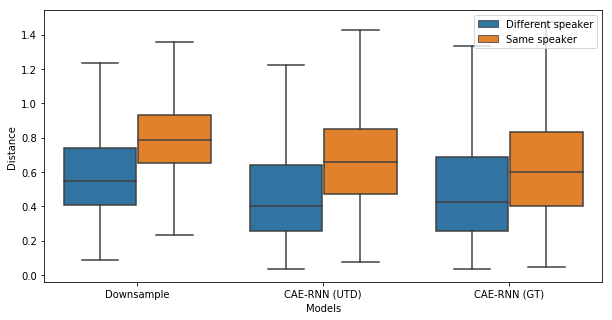

In [135]:
# Box plot
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(data=df_speaker, ax=ax, x="model", y="distance", hue="match", order=models[:-1], showfliers=False)
handles, lables = ax.get_legend_handles_labels()
ax.legend(handles, ["Different speaker", "Same speaker"], loc="upper right")
ax.set_xticklabels(model_titles[:-1])
plt.xlabel("Models")
plt.ylabel("Distance")
plt.savefig(path.join("doc", language.lower() + ".speaker_boxplot.pdf"))

## Number of phones and segment duration

In [137]:
# Pronunciations
pron_fn = path.join("lists", language, "dev.prons")
print("Reading:", pron_fn)
pronunciations = analyse_pairs.read_pronunciations(pron_fn)
pron_labels = []
for utt_key in utt_keys:
    pron_labels.append(pronunciations[utt_key])

# Get distances
print("Getting edit distances:")
edit_distances = analyse_pairs.editdistance_array(pron_labels)

Reading: lists/SW/dev.prons



  0%|          | 0/3916 [00:00<?, ?it/s]

Getting edit distances:



  1%|          | 29/3916 [00:05<11:29,  5.63it/s]

KeyboardInterrupt: 

In [97]:
# Save intermediate edit distances
import pickle
fn = path.join("doc", language.lower() + ".edit_distances.pkl")
if not path.isfile(fn):
    print("Writing:", fn)
    with open(fn, "wb") as f:
        pickle.dump(edit_distances, f, -1)
else:
    print("Reading:", fn)
    with open(fn, "rb") as f:
        edit_distances = pickle.load(f)

Writing: doc/ha.edit_distances.pkl


In [98]:
# Collect distances
edits = sorted(set(edit_distances))
data_edit_distance = []
averages = {}
stds = {}
for model in models:
    print("Collecting distances:", model)
    averages[model] = []
    stds[model] = []
    for edit in tqdm(edits):
        averages[model].append(np.mean(distances[model][edit_distances == edit]))
        stds[model].append(np.std(distances[model][edit_distances == edit]))
    averages[model] = np.array(averages[model])
    stds[model] = np.array(stds[model])

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 154.77it/s]

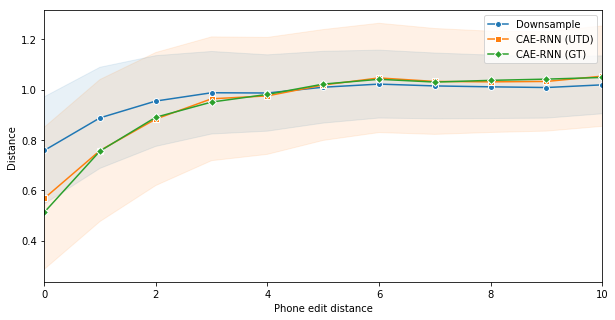

In [103]:
# Plot
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(edits, averages["downsample"], "C0o-", label="Downsample", markeredgecolor="white")
plt.fill_between(edits, averages["downsample"] - stds["downsample"], averages["downsample"] + stds["downsample"], alpha=0.1, color="C0")
plt.plot(edits, averages["cae_utd"], "C1s-", label="CAE-RNN (UTD)",  markeredgecolor="white")
plt.fill_between(edits, averages["cae_utd"] - stds["cae_utd"], averages["cae_utd"] + stds["cae_utd"], alpha=0.1, color="C1")
plt.plot(edits, averages["cae_gt"], "C2D-", label="CAE-RNN (GT)",  markeredgecolor="white")
# plt.fill_between(edits, averages["cae_gt"] - stds["cae_gt"], averages["cae_gt"] + stds["cae_gt"], alpha=0.1, color="C2")
plt.xlim([0, 10])
plt.legend()
plt.xlabel("Phone edit distance")
plt.ylabel("Distance")
plt.savefig(path.join("doc", language.lower() + ".edit_distances.pdf"))

In [104]:
# Distance vs. duration

def get_duration(utt_key):
    _, _, _, interval = utt_key.split("_")
    interval = [int(i) for i in interval.split("-")]
    return interval[1] - interval[0]

N = len(utt_keys)
duration_diffs = np.zeros(int(N*(N - 1)/2))

# Calculate the absolute duration difference for every pair of labels
print("Calculating duration differences:")
cur_duration_i = 0
for n in tqdm(range(N - 1)):
    cur_utt_key = utt_keys[n]
    for i_offset, test_utt_key in enumerate(utt_keys[n + 1:]):
        duration_diffs[cur_duration_i + i_offset] = abs(get_duration(cur_utt_key) - get_duration(test_utt_key))
    cur_duration_i += N - n - 1

  1%|          | 14/1947 [00:00<00:14, 135.11it/s]

Calculating duration differences:


100%|██████████| 1947/1947 [00:05<00:00, 339.84it/s]


/home/kamperh/tools/py3/lib/python3.5/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/kamperh/tools/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


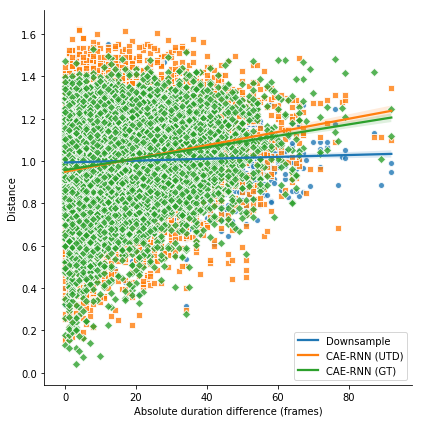

In [108]:
# Select random indices
np.random.seed(1)
indices = np.arange(duration_diffs.shape[0])
np.random.shuffle(indices)
indices = indices[:10000]

# # Temp
# indices = np.where(word_matches)[0]
# print(len(indices))

# Dataframe
data_duration = []
for model in models:
    data_duration += [[model, duration_diffs[i], distances[model][i]] for i in indices]
df_duration = pd.DataFrame(data_duration, columns=["model", "duration_diff", "distance"])
    
# Scatter plot
ax = sns.lmplot(data=df_duration[df_duration.model != "multiling"], x="duration_diff", y="distance", hue="model", truncate=True, scatter_kws={"edgecolor": "white"}, markers=["o", "s", "D"], size=6)
ax._legend.remove()
plt.xlabel("Absolute duration difference (frames)")
plt.ylabel("Distance")
plt.legend(["Downsample", "CAE-RNN (UTD)", "CAE-RNN (GT)"], loc="lower right")
plt.savefig(path.join("doc", language.lower() + ".duration_vs_distance.pdf"))

## Bias in edit operations

In [138]:
# Single edit operations (ins, del, sub)
data_single_edits = []
N = len(utt_keys)
i_global = 0
for n in tqdm(range(N - 1)):
    cur_label = pron_labels[n]
    # distances = []
    for i_offset, test_label in enumerate(pron_labels[n + 1:]):
        a = dp_align.dp_align(cur_label, test_label)
        if a.get_levenshtein() == 1:
            for model in models:
                if a.n_del == 1:
                    data_single_edits.append([model, distances[model][i_global + i_offset], "del"])
                elif a.n_ins == 1:
                    data_single_edits.append([model, distances[model][i_global + i_offset], "ins"])
                elif a.n_sub == 1:
                    data_single_edits.append([model, distances[model][i_global + i_offset], "sub"])
    i_global += N - n - 1    



  0%|          | 0/3916 [00:00<?, ?it/s]

  0%|          | 1/3916 [00:00<13:11,  4.95it/s]

  0%|          | 2/3916 [00:00<12:59,  5.02it/s]

  0%|          | 3/3916 [00:00<12:24,  5.26it/s]

  0%|          | 4/3916 [00:00<12:41,  5.14it/s]

  0%|          | 5/3916 [00:00<12:17,  5.31it/s]

  0%|          | 6/3916 [00:01<12:11,  5.34it/s]

  0%|          | 7/3916 [00:01<12:17,  5.30it/s]

  0%|          | 8/3916 [00:01<12:03,  5.40it/s]

  0%|          | 9/3916 [00:01<11:44,  5.55it/s]

  0%|          | 10/3916 [00:01<11:40,  5.58it/s]

  0%|          | 11/3916 [00:02<11:21,  5.73it/s]

  0%|          | 12/3916 [00:02<11:25,  5.70it/s]

  0%|          | 13/3916 [00:02<11:27,  5.68it/s]

  0%|          | 14/3916 [00:02<11:19,  5.75it/s]

  0%|          | 15/3916 [00:02<11:12,  5.80it/s]

  0%|          | 16/3916 [00:02<11:35,  5.61it/s]

  0%|          | 17/3916 [00:03<11:51,  5.48it/s]

  0%|          | 18/3916 [00:03<11:29,  5.65it/s]

  0%|          | 19/3916 [00:03<11:24,  5.69it/

  4%|▎         | 143/3916 [00:31<08:52,  7.09it/s]

  4%|▎         | 144/3916 [00:32<08:52,  7.08it/s]

  4%|▎         | 145/3916 [00:32<08:57,  7.02it/s]

  4%|▎         | 146/3916 [00:32<09:05,  6.91it/s]

  4%|▍         | 147/3916 [00:32<09:06,  6.90it/s]

  4%|▍         | 148/3916 [00:32<08:56,  7.02it/s]

  4%|▍         | 149/3916 [00:32<08:58,  6.99it/s]

  4%|▍         | 150/3916 [00:32<08:54,  7.05it/s]

  4%|▍         | 151/3916 [00:33<09:35,  6.54it/s]

  4%|▍         | 152/3916 [00:33<09:29,  6.60it/s]

  4%|▍         | 153/3916 [00:33<09:08,  6.86it/s]

  4%|▍         | 154/3916 [00:33<09:02,  6.94it/s]

  4%|▍         | 155/3916 [00:33<09:06,  6.89it/s]

  4%|▍         | 156/3916 [00:33<09:39,  6.48it/s]

  4%|▍         | 157/3916 [00:34<09:25,  6.65it/s]

  4%|▍         | 158/3916 [00:34<09:26,  6.63it/s]

  4%|▍         | 159/3916 [00:34<09:44,  6.42it/s]

  4%|▍         | 160/3916 [00:34<09:14,  6.78it/s]

  4%|▍         | 161/3916 [00:34<09:10,  6.82it/s]

  4%|▍      

  7%|▋         | 284/3916 [00:53<08:10,  7.40it/s]

  7%|▋         | 285/3916 [00:53<08:07,  7.45it/s]

  7%|▋         | 286/3916 [00:53<08:34,  7.06it/s]

  7%|▋         | 287/3916 [00:53<08:35,  7.05it/s]

  7%|▋         | 288/3916 [00:53<08:45,  6.91it/s]

  7%|▋         | 289/3916 [00:53<08:34,  7.05it/s]

  7%|▋         | 290/3916 [00:53<07:55,  7.63it/s]

  7%|▋         | 291/3916 [00:53<07:56,  7.61it/s]

  7%|▋         | 292/3916 [00:54<08:55,  6.77it/s]

  7%|▋         | 293/3916 [00:54<09:35,  6.29it/s]

  8%|▊         | 294/3916 [00:54<10:43,  5.62it/s]

  8%|▊         | 295/3916 [00:54<10:42,  5.63it/s]

  8%|▊         | 296/3916 [00:54<11:26,  5.27it/s]

  8%|▊         | 297/3916 [00:55<11:34,  5.21it/s]

  8%|▊         | 298/3916 [00:55<11:35,  5.20it/s]

  8%|▊         | 299/3916 [00:55<11:48,  5.10it/s]

  8%|▊         | 300/3916 [00:55<11:43,  5.14it/s]

  8%|▊         | 301/3916 [00:55<11:30,  5.23it/s]

  8%|▊         | 302/3916 [00:56<11:32,  5.22it/s]

  8%|▊      

 11%|█         | 425/3916 [01:20<10:41,  5.44it/s]

 11%|█         | 426/3916 [01:21<10:49,  5.37it/s]

 11%|█         | 427/3916 [01:21<10:48,  5.38it/s]

 11%|█         | 428/3916 [01:21<11:25,  5.09it/s]

 11%|█         | 429/3916 [01:21<11:07,  5.22it/s]

 11%|█         | 430/3916 [01:21<11:03,  5.25it/s]

 11%|█         | 431/3916 [01:21<10:43,  5.41it/s]

 11%|█         | 432/3916 [01:22<10:29,  5.53it/s]

 11%|█         | 433/3916 [01:22<10:09,  5.72it/s]

 11%|█         | 434/3916 [01:22<09:58,  5.82it/s]

 11%|█         | 435/3916 [01:22<09:51,  5.88it/s]

 11%|█         | 436/3916 [01:22<09:42,  5.98it/s]

 11%|█         | 437/3916 [01:22<09:39,  6.01it/s]

 11%|█         | 438/3916 [01:23<09:56,  5.83it/s]

 11%|█         | 439/3916 [01:23<09:46,  5.93it/s]

 11%|█         | 440/3916 [01:23<09:43,  5.96it/s]

 11%|█▏        | 441/3916 [01:23<09:29,  6.10it/s]

 11%|█▏        | 442/3916 [01:23<09:25,  6.15it/s]

 11%|█▏        | 443/3916 [01:23<09:12,  6.29it/s]

 11%|█▏     

 14%|█▍        | 566/3916 [01:44<07:13,  7.73it/s]

 14%|█▍        | 567/3916 [01:44<07:17,  7.66it/s]

 15%|█▍        | 568/3916 [01:44<08:56,  6.25it/s]

 15%|█▍        | 569/3916 [01:45<09:57,  5.60it/s]

 15%|█▍        | 570/3916 [01:45<10:48,  5.16it/s]

 15%|█▍        | 571/3916 [01:45<11:11,  4.98it/s]

 15%|█▍        | 572/3916 [01:45<11:36,  4.80it/s]

 15%|█▍        | 573/3916 [01:46<11:47,  4.72it/s]

 15%|█▍        | 574/3916 [01:46<12:07,  4.59it/s]

 15%|█▍        | 575/3916 [01:46<12:24,  4.49it/s]

 15%|█▍        | 576/3916 [01:46<12:23,  4.49it/s]

 15%|█▍        | 577/3916 [01:46<12:29,  4.45it/s]

 15%|█▍        | 578/3916 [01:47<12:34,  4.42it/s]

 15%|█▍        | 579/3916 [01:47<12:35,  4.41it/s]

 15%|█▍        | 580/3916 [01:47<12:33,  4.43it/s]

 15%|█▍        | 581/3916 [01:47<12:36,  4.41it/s]

 15%|█▍        | 582/3916 [01:48<11:21,  4.89it/s]

 15%|█▍        | 583/3916 [01:48<10:34,  5.25it/s]

 15%|█▍        | 584/3916 [01:48<10:23,  5.34it/s]

 15%|█▍     

 18%|█▊        | 707/3916 [02:09<13:07,  4.07it/s]

 18%|█▊        | 708/3916 [02:09<12:00,  4.45it/s]

 18%|█▊        | 709/3916 [02:09<10:57,  4.88it/s]

 18%|█▊        | 710/3916 [02:09<10:37,  5.03it/s]

 18%|█▊        | 711/3916 [02:09<10:09,  5.26it/s]

 18%|█▊        | 712/3916 [02:09<09:53,  5.40it/s]

 18%|█▊        | 713/3916 [02:10<09:46,  5.46it/s]

 18%|█▊        | 714/3916 [02:10<09:28,  5.63it/s]

 18%|█▊        | 715/3916 [02:10<09:22,  5.69it/s]

 18%|█▊        | 716/3916 [02:10<09:19,  5.72it/s]

 18%|█▊        | 717/3916 [02:10<09:10,  5.81it/s]

 18%|█▊        | 718/3916 [02:10<09:05,  5.87it/s]

 18%|█▊        | 719/3916 [02:11<09:22,  5.68it/s]

 18%|█▊        | 720/3916 [02:11<09:19,  5.71it/s]

 18%|█▊        | 721/3916 [02:11<09:12,  5.78it/s]

 18%|█▊        | 722/3916 [02:11<09:14,  5.76it/s]

 18%|█▊        | 723/3916 [02:11<09:13,  5.77it/s]

 18%|█▊        | 724/3916 [02:12<09:04,  5.86it/s]

 19%|█▊        | 725/3916 [02:12<09:01,  5.90it/s]

 19%|█▊     

 22%|██▏       | 848/3916 [02:32<08:25,  6.06it/s]

 22%|██▏       | 849/3916 [02:32<08:17,  6.17it/s]

 22%|██▏       | 850/3916 [02:32<08:13,  6.22it/s]

 22%|██▏       | 851/3916 [02:33<08:38,  5.91it/s]

 22%|██▏       | 852/3916 [02:33<08:36,  5.93it/s]

 22%|██▏       | 853/3916 [02:33<09:00,  5.67it/s]

 22%|██▏       | 854/3916 [02:33<09:12,  5.54it/s]

 22%|██▏       | 855/3916 [02:33<09:00,  5.66it/s]

 22%|██▏       | 856/3916 [02:34<08:47,  5.80it/s]

 22%|██▏       | 857/3916 [02:34<08:59,  5.67it/s]

 22%|██▏       | 858/3916 [02:34<08:44,  5.83it/s]

 22%|██▏       | 859/3916 [02:34<08:28,  6.01it/s]

 22%|██▏       | 860/3916 [02:34<08:22,  6.08it/s]

 22%|██▏       | 861/3916 [02:34<08:49,  5.77it/s]

 22%|██▏       | 862/3916 [02:35<08:36,  5.92it/s]

 22%|██▏       | 863/3916 [02:35<08:32,  5.96it/s]

 22%|██▏       | 864/3916 [02:35<08:56,  5.69it/s]

 22%|██▏       | 865/3916 [02:35<08:49,  5.77it/s]

 22%|██▏       | 866/3916 [02:35<08:37,  5.90it/s]

 22%|██▏    

 25%|██▌       | 989/3916 [02:53<06:33,  7.43it/s]

 25%|██▌       | 990/3916 [02:53<06:26,  7.57it/s]

 25%|██▌       | 991/3916 [02:54<06:16,  7.76it/s]

 25%|██▌       | 992/3916 [02:54<06:18,  7.73it/s]

 25%|██▌       | 993/3916 [02:54<06:06,  7.97it/s]

 25%|██▌       | 994/3916 [02:54<06:04,  8.01it/s]

 25%|██▌       | 995/3916 [02:54<06:05,  8.00it/s]

 25%|██▌       | 996/3916 [02:54<06:03,  8.03it/s]

 25%|██▌       | 997/3916 [02:54<05:56,  8.19it/s]

 25%|██▌       | 998/3916 [02:54<05:54,  8.24it/s]

 26%|██▌       | 999/3916 [02:55<05:56,  8.17it/s]

 26%|██▌       | 1000/3916 [02:55<05:47,  8.39it/s]

 26%|██▌       | 1001/3916 [02:55<05:48,  8.37it/s]

 26%|██▌       | 1002/3916 [02:55<05:52,  8.26it/s]

 26%|██▌       | 1003/3916 [02:55<06:00,  8.09it/s]

 26%|██▌       | 1004/3916 [02:55<05:53,  8.23it/s]

 26%|██▌       | 1005/3916 [02:55<05:44,  8.45it/s]

 26%|██▌       | 1006/3916 [02:55<05:42,  8.50it/s]

 26%|██▌       | 1007/3916 [02:55<05:45,  8.42it/s]

 26%

 29%|██▉       | 1128/3916 [03:13<07:14,  6.42it/s]

 29%|██▉       | 1129/3916 [03:13<07:20,  6.33it/s]

 29%|██▉       | 1130/3916 [03:14<07:17,  6.37it/s]

 29%|██▉       | 1131/3916 [03:14<07:20,  6.32it/s]

 29%|██▉       | 1132/3916 [03:14<07:14,  6.41it/s]

 29%|██▉       | 1133/3916 [03:14<07:20,  6.31it/s]

 29%|██▉       | 1134/3916 [03:14<07:21,  6.30it/s]

 29%|██▉       | 1135/3916 [03:14<07:08,  6.49it/s]

 29%|██▉       | 1136/3916 [03:14<07:11,  6.44it/s]

 29%|██▉       | 1137/3916 [03:15<07:29,  6.19it/s]

 29%|██▉       | 1138/3916 [03:15<07:26,  6.22it/s]

 29%|██▉       | 1139/3916 [03:15<07:19,  6.32it/s]

 29%|██▉       | 1140/3916 [03:15<07:08,  6.47it/s]

 29%|██▉       | 1141/3916 [03:15<07:08,  6.48it/s]

 29%|██▉       | 1142/3916 [03:15<07:13,  6.40it/s]

 29%|██▉       | 1143/3916 [03:16<07:13,  6.39it/s]

 29%|██▉       | 1144/3916 [03:16<07:11,  6.43it/s]

 29%|██▉       | 1145/3916 [03:16<07:21,  6.28it/s]

 29%|██▉       | 1146/3916 [03:16<07:25,  6.21

 32%|███▏      | 1266/3916 [03:37<06:37,  6.66it/s]

 32%|███▏      | 1267/3916 [03:38<06:36,  6.68it/s]

 32%|███▏      | 1268/3916 [03:38<07:09,  6.16it/s]

 32%|███▏      | 1269/3916 [03:38<07:34,  5.82it/s]

 32%|███▏      | 1270/3916 [03:38<07:42,  5.72it/s]

 32%|███▏      | 1271/3916 [03:38<07:46,  5.67it/s]

 32%|███▏      | 1272/3916 [03:39<07:53,  5.58it/s]

 33%|███▎      | 1273/3916 [03:39<08:02,  5.47it/s]

 33%|███▎      | 1274/3916 [03:39<08:12,  5.37it/s]

 33%|███▎      | 1275/3916 [03:39<08:21,  5.27it/s]

 33%|███▎      | 1276/3916 [03:39<08:16,  5.32it/s]

 33%|███▎      | 1277/3916 [03:40<08:33,  5.14it/s]

 33%|███▎      | 1278/3916 [03:40<07:55,  5.54it/s]

 33%|███▎      | 1279/3916 [03:40<07:34,  5.81it/s]

 33%|███▎      | 1280/3916 [03:40<07:16,  6.04it/s]

 33%|███▎      | 1281/3916 [03:40<07:13,  6.08it/s]

 33%|███▎      | 1282/3916 [03:40<07:07,  6.16it/s]

 33%|███▎      | 1283/3916 [03:40<07:08,  6.14it/s]

 33%|███▎      | 1284/3916 [03:41<06:56,  6.31

 36%|███▌      | 1404/3916 [03:57<06:48,  6.16it/s]

 36%|███▌      | 1405/3916 [03:58<06:47,  6.16it/s]

 36%|███▌      | 1406/3916 [03:58<06:46,  6.18it/s]

 36%|███▌      | 1407/3916 [03:58<06:51,  6.10it/s]

 36%|███▌      | 1408/3916 [03:58<06:51,  6.10it/s]

 36%|███▌      | 1409/3916 [03:58<06:43,  6.22it/s]

 36%|███▌      | 1410/3916 [03:58<06:46,  6.17it/s]

 36%|███▌      | 1411/3916 [03:58<06:42,  6.22it/s]

 36%|███▌      | 1412/3916 [03:59<06:28,  6.45it/s]

 36%|███▌      | 1413/3916 [03:59<06:20,  6.57it/s]

 36%|███▌      | 1414/3916 [03:59<06:14,  6.69it/s]

 36%|███▌      | 1415/3916 [03:59<06:10,  6.76it/s]

 36%|███▌      | 1416/3916 [03:59<06:14,  6.68it/s]

 36%|███▌      | 1417/3916 [03:59<06:06,  6.83it/s]

 36%|███▌      | 1418/3916 [03:59<05:58,  6.97it/s]

 36%|███▌      | 1419/3916 [04:00<06:01,  6.92it/s]

 36%|███▋      | 1420/3916 [04:00<05:55,  7.02it/s]

 36%|███▋      | 1421/3916 [04:00<05:58,  6.97it/s]

 36%|███▋      | 1422/3916 [04:00<05:54,  7.03

 39%|███▉      | 1542/3916 [04:16<04:38,  8.51it/s]

 39%|███▉      | 1543/3916 [04:16<04:36,  8.58it/s]

 39%|███▉      | 1544/3916 [04:16<04:34,  8.64it/s]

 39%|███▉      | 1545/3916 [04:16<04:35,  8.60it/s]

 39%|███▉      | 1546/3916 [04:16<04:39,  8.48it/s]

 40%|███▉      | 1547/3916 [04:16<04:50,  8.15it/s]

 40%|███▉      | 1548/3916 [04:17<04:50,  8.14it/s]

 40%|███▉      | 1549/3916 [04:17<04:52,  8.09it/s]

 40%|███▉      | 1550/3916 [04:17<04:49,  8.17it/s]

 40%|███▉      | 1551/3916 [04:17<04:55,  7.99it/s]

 40%|███▉      | 1552/3916 [04:17<04:59,  7.89it/s]

 40%|███▉      | 1553/3916 [04:17<04:53,  8.06it/s]

 40%|███▉      | 1554/3916 [04:17<04:48,  8.19it/s]

 40%|███▉      | 1555/3916 [04:17<04:41,  8.38it/s]

 40%|███▉      | 1556/3916 [04:18<04:50,  8.11it/s]

 40%|███▉      | 1557/3916 [04:18<04:51,  8.09it/s]

 40%|███▉      | 1558/3916 [04:18<04:46,  8.22it/s]

 40%|███▉      | 1559/3916 [04:18<04:33,  8.63it/s]

 40%|███▉      | 1560/3916 [04:18<04:25,  8.87

 43%|████▎     | 1689/3916 [04:35<04:10,  8.88it/s]

 43%|████▎     | 1690/3916 [04:35<04:06,  9.02it/s]

 43%|████▎     | 1691/3916 [04:35<04:11,  8.84it/s]

 43%|████▎     | 1692/3916 [04:35<04:16,  8.66it/s]

 43%|████▎     | 1693/3916 [04:35<04:19,  8.56it/s]

 43%|████▎     | 1694/3916 [04:35<04:24,  8.41it/s]

 43%|████▎     | 1695/3916 [04:35<04:16,  8.64it/s]

 43%|████▎     | 1696/3916 [04:35<04:14,  8.73it/s]

 43%|████▎     | 1697/3916 [04:36<04:12,  8.77it/s]

 43%|████▎     | 1698/3916 [04:36<04:12,  8.78it/s]

 43%|████▎     | 1699/3916 [04:36<04:25,  8.34it/s]

 43%|████▎     | 1700/3916 [04:36<04:15,  8.69it/s]

 43%|████▎     | 1701/3916 [04:36<04:11,  8.80it/s]

 43%|████▎     | 1702/3916 [04:36<04:34,  8.06it/s]

 43%|████▎     | 1703/3916 [04:36<04:47,  7.71it/s]

 44%|████▎     | 1704/3916 [04:36<04:58,  7.42it/s]

 44%|████▎     | 1705/3916 [04:37<05:08,  7.16it/s]

 44%|████▎     | 1706/3916 [04:37<05:21,  6.87it/s]

 44%|████▎     | 1707/3916 [04:37<05:23,  6.82

 47%|████▋     | 1832/3916 [04:54<03:34,  9.72it/s]

 47%|████▋     | 1833/3916 [04:54<03:37,  9.58it/s]

 47%|████▋     | 1835/3916 [04:54<03:24, 10.17it/s]

 47%|████▋     | 1837/3916 [04:54<03:05, 11.22it/s]

 47%|████▋     | 1839/3916 [04:54<02:48, 12.30it/s]

 47%|████▋     | 1841/3916 [04:54<02:38, 13.09it/s]

 47%|████▋     | 1843/3916 [04:54<02:36, 13.23it/s]

 47%|████▋     | 1845/3916 [04:55<02:26, 14.13it/s]

 47%|████▋     | 1847/3916 [04:55<02:23, 14.44it/s]

 47%|████▋     | 1849/3916 [04:55<02:21, 14.56it/s]

 47%|████▋     | 1851/3916 [04:55<02:30, 13.76it/s]

 47%|████▋     | 1853/3916 [04:55<02:25, 14.20it/s]

 47%|████▋     | 1855/3916 [04:55<02:20, 14.68it/s]

 47%|████▋     | 1857/3916 [04:55<02:17, 14.98it/s]

 47%|████▋     | 1859/3916 [04:56<02:21, 14.59it/s]

 48%|████▊     | 1861/3916 [04:56<02:16, 15.01it/s]

 48%|████▊     | 1863/3916 [04:56<02:19, 14.77it/s]

 48%|████▊     | 1865/3916 [04:56<02:30, 13.61it/s]

 48%|████▊     | 1867/3916 [04:56<02:33, 13.34

 51%|█████     | 2005/3916 [05:13<05:50,  5.45it/s]

 51%|█████     | 2006/3916 [05:13<06:02,  5.27it/s]

 51%|█████▏    | 2007/3916 [05:13<05:56,  5.35it/s]

 51%|█████▏    | 2008/3916 [05:13<05:53,  5.40it/s]

 51%|█████▏    | 2009/3916 [05:13<05:57,  5.33it/s]

 51%|█████▏    | 2010/3916 [05:14<05:54,  5.38it/s]

 51%|█████▏    | 2011/3916 [05:14<05:53,  5.39it/s]

 51%|█████▏    | 2012/3916 [05:14<06:00,  5.28it/s]

 51%|█████▏    | 2013/3916 [05:14<05:58,  5.30it/s]

 51%|█████▏    | 2014/3916 [05:14<05:55,  5.36it/s]

 51%|█████▏    | 2015/3916 [05:14<05:57,  5.32it/s]

 51%|█████▏    | 2016/3916 [05:15<05:57,  5.31it/s]

 52%|█████▏    | 2017/3916 [05:15<05:11,  6.09it/s]

 52%|█████▏    | 2018/3916 [05:15<04:41,  6.74it/s]

 52%|█████▏    | 2019/3916 [05:15<04:22,  7.22it/s]

 52%|█████▏    | 2020/3916 [05:15<04:04,  7.75it/s]

 52%|█████▏    | 2021/3916 [05:15<03:52,  8.16it/s]

 52%|█████▏    | 2022/3916 [05:15<03:40,  8.58it/s]

 52%|█████▏    | 2023/3916 [05:15<03:35,  8.79

 55%|█████▍    | 2145/3916 [05:31<03:13,  9.14it/s]

 55%|█████▍    | 2147/3916 [05:32<02:59,  9.86it/s]

 55%|█████▍    | 2149/3916 [05:32<02:55, 10.09it/s]

 55%|█████▍    | 2151/3916 [05:32<02:46, 10.62it/s]

 55%|█████▍    | 2153/3916 [05:32<02:40, 10.97it/s]

 55%|█████▌    | 2155/3916 [05:32<02:38, 11.09it/s]

 55%|█████▌    | 2157/3916 [05:32<02:36, 11.23it/s]

 55%|█████▌    | 2159/3916 [05:33<02:37, 11.15it/s]

 55%|█████▌    | 2161/3916 [05:33<02:34, 11.35it/s]

 55%|█████▌    | 2163/3916 [05:33<02:31, 11.55it/s]

 55%|█████▌    | 2165/3916 [05:33<02:35, 11.26it/s]

 55%|█████▌    | 2167/3916 [05:33<02:37, 11.08it/s]

 55%|█████▌    | 2169/3916 [05:34<02:44, 10.64it/s]

 55%|█████▌    | 2171/3916 [05:34<02:42, 10.74it/s]

 55%|█████▌    | 2173/3916 [05:34<02:41, 10.76it/s]

 56%|█████▌    | 2175/3916 [05:34<02:43, 10.67it/s]

 56%|█████▌    | 2177/3916 [05:34<02:42, 10.68it/s]

 56%|█████▌    | 2179/3916 [05:35<02:44, 10.57it/s]

 56%|█████▌    | 2181/3916 [05:35<02:43, 10.60

 60%|██████    | 2360/3916 [05:53<02:44,  9.46it/s]

 60%|██████    | 2362/3916 [05:53<02:54,  8.89it/s]

 60%|██████    | 2363/3916 [05:53<03:07,  8.27it/s]

 60%|██████    | 2364/3916 [05:53<03:21,  7.69it/s]

 60%|██████    | 2365/3916 [05:54<03:23,  7.62it/s]

 60%|██████    | 2366/3916 [05:54<03:30,  7.38it/s]

 60%|██████    | 2367/3916 [05:54<03:35,  7.20it/s]

 60%|██████    | 2368/3916 [05:54<03:40,  7.02it/s]

 60%|██████    | 2369/3916 [05:54<03:44,  6.89it/s]

 61%|██████    | 2370/3916 [05:54<03:43,  6.90it/s]

 61%|██████    | 2371/3916 [05:54<03:49,  6.73it/s]

 61%|██████    | 2372/3916 [05:55<03:47,  6.80it/s]

 61%|██████    | 2373/3916 [05:55<03:49,  6.74it/s]

 61%|██████    | 2374/3916 [05:55<03:48,  6.74it/s]

 61%|██████    | 2375/3916 [05:55<03:47,  6.78it/s]

 61%|██████    | 2376/3916 [05:55<03:47,  6.76it/s]

 61%|██████    | 2377/3916 [05:55<03:44,  6.84it/s]

 61%|██████    | 2378/3916 [05:55<03:41,  6.95it/s]

 61%|██████    | 2379/3916 [05:56<03:43,  6.88

 66%|██████▌   | 2581/3916 [06:14<01:26, 15.48it/s]

 66%|██████▌   | 2583/3916 [06:14<01:25, 15.66it/s]

 66%|██████▌   | 2585/3916 [06:14<01:39, 13.36it/s]

 66%|██████▌   | 2587/3916 [06:14<01:39, 13.40it/s]

 66%|██████▌   | 2589/3916 [06:14<01:43, 12.77it/s]

 66%|██████▌   | 2591/3916 [06:15<01:47, 12.38it/s]

 66%|██████▌   | 2593/3916 [06:15<02:00, 10.98it/s]

 66%|██████▋   | 2595/3916 [06:15<01:56, 11.33it/s]

 66%|██████▋   | 2597/3916 [06:15<01:52, 11.69it/s]

 66%|██████▋   | 2599/3916 [06:15<02:09, 10.21it/s]

 66%|██████▋   | 2601/3916 [06:16<02:05, 10.50it/s]

 66%|██████▋   | 2603/3916 [06:16<01:58, 11.04it/s]

 67%|██████▋   | 2605/3916 [06:16<01:51, 11.73it/s]

 67%|██████▋   | 2607/3916 [06:16<01:47, 12.14it/s]

 67%|██████▋   | 2609/3916 [06:16<01:47, 12.18it/s]

 67%|██████▋   | 2611/3916 [06:16<01:55, 11.33it/s]

 67%|██████▋   | 2613/3916 [06:17<01:56, 11.19it/s]

 67%|██████▋   | 2615/3916 [06:17<01:54, 11.31it/s]

 67%|██████▋   | 2617/3916 [06:17<02:03, 10.52

 72%|███████▏  | 2819/3916 [06:36<01:58,  9.23it/s]

 72%|███████▏  | 2820/3916 [06:36<01:56,  9.38it/s]

 72%|███████▏  | 2821/3916 [06:37<01:57,  9.33it/s]

 72%|███████▏  | 2823/3916 [06:37<01:50,  9.87it/s]

 72%|███████▏  | 2825/3916 [06:37<01:45, 10.35it/s]

 72%|███████▏  | 2827/3916 [06:37<01:43, 10.52it/s]

 72%|███████▏  | 2829/3916 [06:37<01:40, 10.80it/s]

 72%|███████▏  | 2831/3916 [06:37<01:37, 11.13it/s]

 72%|███████▏  | 2833/3916 [06:38<01:36, 11.25it/s]

 72%|███████▏  | 2835/3916 [06:38<01:34, 11.42it/s]

 72%|███████▏  | 2837/3916 [06:38<01:33, 11.53it/s]

 72%|███████▏  | 2839/3916 [06:38<01:32, 11.69it/s]

 73%|███████▎  | 2841/3916 [06:38<01:32, 11.64it/s]

 73%|███████▎  | 2843/3916 [06:38<01:30, 11.83it/s]

 73%|███████▎  | 2845/3916 [06:39<01:29, 11.91it/s]

 73%|███████▎  | 2847/3916 [06:39<01:27, 12.18it/s]

 73%|███████▎  | 2849/3916 [06:39<01:23, 12.74it/s]

 73%|███████▎  | 2851/3916 [06:39<01:20, 13.30it/s]

 73%|███████▎  | 2853/3916 [06:39<01:17, 13.73

 80%|███████▉  | 3115/3916 [06:58<00:34, 23.50it/s]

 80%|███████▉  | 3118/3916 [06:58<00:35, 22.43it/s]

 80%|███████▉  | 3121/3916 [06:58<00:32, 24.11it/s]

 80%|███████▉  | 3124/3916 [06:58<00:39, 20.24it/s]

 80%|███████▉  | 3127/3916 [06:58<00:43, 18.08it/s]

 80%|███████▉  | 3130/3916 [06:58<00:40, 19.30it/s]

 80%|████████  | 3133/3916 [06:59<00:45, 17.29it/s]

 80%|████████  | 3135/3916 [06:59<00:45, 17.28it/s]

 80%|████████  | 3138/3916 [06:59<00:40, 19.23it/s]

 80%|████████  | 3141/3916 [06:59<00:37, 20.54it/s]

 80%|████████  | 3144/3916 [06:59<00:34, 22.36it/s]

 80%|████████  | 3148/3916 [06:59<00:34, 22.25it/s]

 80%|████████  | 3151/3916 [07:00<00:43, 17.46it/s]

 81%|████████  | 3153/3916 [07:00<00:53, 14.31it/s]

 81%|████████  | 3156/3916 [07:00<00:46, 16.47it/s]

 81%|████████  | 3159/3916 [07:00<00:40, 18.87it/s]

 81%|████████  | 3162/3916 [07:00<00:36, 20.84it/s]

 81%|████████  | 3165/3916 [07:00<00:34, 21.77it/s]

 81%|████████  | 3168/3916 [07:00<00:32, 23.03

 93%|█████████▎| 3623/3916 [07:16<00:08, 35.52it/s]

 93%|█████████▎| 3628/3916 [07:16<00:09, 30.44it/s]

 93%|█████████▎| 3632/3916 [07:17<00:09, 28.81it/s]

 93%|█████████▎| 3638/3916 [07:17<00:08, 32.71it/s]

 93%|█████████▎| 3642/3916 [07:17<00:08, 31.38it/s]

 93%|█████████▎| 3647/3916 [07:17<00:07, 35.31it/s]

 93%|█████████▎| 3651/3916 [07:17<00:07, 35.17it/s]

 93%|█████████▎| 3658/3916 [07:17<00:06, 40.61it/s]

 94%|█████████▎| 3668/3916 [07:17<00:05, 48.42it/s]

 94%|█████████▍| 3676/3916 [07:17<00:04, 53.83it/s]

 94%|█████████▍| 3687/3916 [07:17<00:03, 63.39it/s]

 94%|█████████▍| 3699/3916 [07:18<00:02, 73.56it/s]

 95%|█████████▍| 3710/3916 [07:18<00:02, 81.67it/s]

 95%|█████████▌| 3722/3916 [07:18<00:02, 89.15it/s]

 95%|█████████▌| 3733/3916 [07:18<00:01, 93.54it/s]

 96%|█████████▌| 3744/3916 [07:18<00:01, 92.48it/s]

 96%|█████████▌| 3754/3916 [07:18<00:01, 94.20it/s]

 96%|█████████▌| 3764/3916 [07:18<00:01, 95.19it/s]

 96%|█████████▋| 3776/3916 [07:18<00:01, 99.53

In [139]:
# Save intermediate edit distances
import pickle
fn = path.join("doc", language.lower() + ".single_edit_distances.pkl")
if not path.isfile(fn):
    print("Writing:", fn)
    with open(fn, "wb") as f:
        pickle.dump(data_single_edits, f, -1)
else:
    print("Reading:", fn)
    with open(fn, "rb") as f:
        data_single_edits = pickle.load(f)

Writing: doc/sw.single_edit_distances.pkl


In [140]:
df_single_edits = pd.DataFrame(data_single_edits, columns=["model", "distance", "error"])

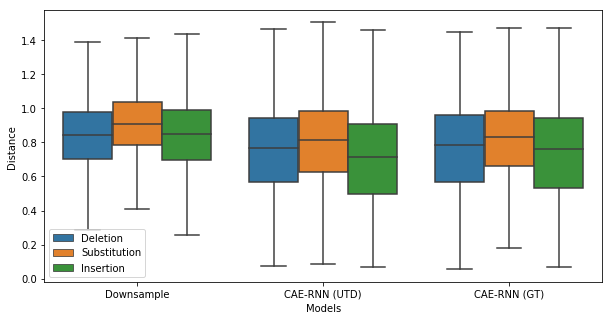

In [145]:
# Box plot
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(data=df_single_edits, ax=ax, x="model", y="distance", hue="error", order=models[:-1], showfliers=False)
ax.set_xticklabels(model_titles[:-1])
handles, lables = ax.get_legend_handles_labels()
ax.legend(handles, ["Deletion", "Substitution", "Insertion"], loc="lower left")
plt.xlabel("Models")
plt.ylabel("Distance")
plt.savefig(path.join("doc", language.lower() + ".single_edit_boxplot.pdf"))

In [143]:
# Example
a, start, middle, end = analyse_pairs.dp_align_edit_positions([1, 12, 4], [1, 12, 4])
print(a, start, middle, end)

H = 3, D = 0, S = 0, I = 0, N = 3 False False False


In [146]:
# Look at single substitutions
data_edit_positions = []
N = len(utt_keys)
i_global = 0
for n in tqdm(range(N - 1)):
    cur_label = pron_labels[n]
    # distances = []
    for i_offset, test_label in enumerate(pron_labels[n + 1:]):
        dp_error, edit_start, edit_middle, edit_end = analyse_pairs.dp_align_edit_positions(cur_label, test_label)
        if dp_error.get_levenshtein() == 1:
            for model in models:
                if edit_start:
                    data_edit_positions.append([model, distances[model][i_global + i_offset], "start"])
                elif edit_middle:
                    data_edit_positions.append([model, distances[model][i_global + i_offset], "middle"])                    
                elif edit_end:
                    data_edit_positions.append([model, distances[model][i_global + i_offset], "end"])                    
#             print(cur_label, test_label, dp_error, edit_start, edit_end)
    i_global += N - n - 1



  0%|          | 0/3916 [00:00<?, ?it/s]

  0%|          | 1/3916 [00:00<18:35,  3.51it/s]

  0%|          | 2/3916 [00:00<18:04,  3.61it/s]

  0%|          | 3/3916 [00:00<17:04,  3.82it/s]

  0%|          | 4/3916 [00:01<16:31,  3.94it/s]

  0%|          | 5/3916 [00:01<15:52,  4.11it/s]

  0%|          | 6/3916 [00:01<14:48,  4.40it/s]

  0%|          | 7/3916 [00:01<13:59,  4.65it/s]

  0%|          | 8/3916 [00:01<13:17,  4.90it/s]

  0%|          | 9/3916 [00:02<14:53,  4.37it/s]

  0%|          | 10/3916 [00:02<15:45,  4.13it/s]

  0%|          | 11/3916 [00:02<14:29,  4.49it/s]

  0%|          | 12/3916 [00:02<15:36,  4.17it/s]

  0%|          | 13/3916 [00:03<16:15,  4.00it/s]

  0%|          | 14/3916 [00:03<15:15,  4.26it/s]

  0%|          | 15/3916 [00:03<13:54,  4.67it/s]

  0%|          | 16/3916 [00:03<13:55,  4.67it/s]

  0%|          | 17/3916 [00:03<13:39,  4.76it/s]

  0%|          | 18/3916 [00:04<13:05,  4.97it/s]

  0%|          | 19/3916 [00:04<12:52,  5.04it/

  4%|▎         | 143/3916 [00:30<09:19,  6.75it/s]

  4%|▎         | 144/3916 [00:30<09:18,  6.76it/s]

  4%|▎         | 145/3916 [00:31<09:19,  6.74it/s]

  4%|▎         | 146/3916 [00:31<09:14,  6.80it/s]

  4%|▍         | 147/3916 [00:31<09:14,  6.79it/s]

  4%|▍         | 148/3916 [00:31<09:15,  6.78it/s]

  4%|▍         | 149/3916 [00:31<09:23,  6.69it/s]

  4%|▍         | 150/3916 [00:31<09:12,  6.82it/s]

  4%|▍         | 151/3916 [00:31<09:21,  6.70it/s]

  4%|▍         | 152/3916 [00:32<09:30,  6.60it/s]

  4%|▍         | 153/3916 [00:32<09:24,  6.67it/s]

  4%|▍         | 154/3916 [00:32<09:24,  6.66it/s]

  4%|▍         | 155/3916 [00:32<09:18,  6.74it/s]

  4%|▍         | 156/3916 [00:32<09:29,  6.60it/s]

  4%|▍         | 157/3916 [00:32<09:24,  6.66it/s]

  4%|▍         | 158/3916 [00:32<09:11,  6.81it/s]

  4%|▍         | 159/3916 [00:33<09:33,  6.55it/s]

  4%|▍         | 160/3916 [00:33<09:13,  6.78it/s]

  4%|▍         | 161/3916 [00:33<09:03,  6.91it/s]

  4%|▍      

  7%|▋         | 284/3916 [00:52<07:59,  7.57it/s]

  7%|▋         | 285/3916 [00:52<08:12,  7.37it/s]

  7%|▋         | 286/3916 [00:53<08:22,  7.22it/s]

  7%|▋         | 287/3916 [00:53<08:14,  7.34it/s]

  7%|▋         | 288/3916 [00:53<08:16,  7.31it/s]

  7%|▋         | 289/3916 [00:53<08:22,  7.22it/s]

  7%|▋         | 290/3916 [00:53<07:55,  7.63it/s]

  7%|▋         | 291/3916 [00:53<08:08,  7.42it/s]

  7%|▋         | 292/3916 [00:53<09:02,  6.68it/s]

  7%|▋         | 293/3916 [00:54<09:51,  6.12it/s]

  8%|▊         | 294/3916 [00:54<10:43,  5.63it/s]

  8%|▊         | 295/3916 [00:54<11:05,  5.44it/s]

  8%|▊         | 296/3916 [00:54<11:41,  5.16it/s]

  8%|▊         | 297/3916 [00:54<11:35,  5.21it/s]

  8%|▊         | 298/3916 [00:55<11:27,  5.26it/s]

  8%|▊         | 299/3916 [00:55<11:46,  5.12it/s]

  8%|▊         | 300/3916 [00:55<11:45,  5.13it/s]

  8%|▊         | 301/3916 [00:55<11:28,  5.25it/s]

  8%|▊         | 302/3916 [00:55<11:31,  5.22it/s]

  8%|▊      

 11%|█         | 425/3916 [01:21<11:14,  5.18it/s]

 11%|█         | 426/3916 [01:21<13:09,  4.42it/s]

 11%|█         | 427/3916 [01:22<14:36,  3.98it/s]

 11%|█         | 428/3916 [01:22<15:33,  3.74it/s]

 11%|█         | 429/3916 [01:22<13:56,  4.17it/s]

 11%|█         | 430/3916 [01:22<14:20,  4.05it/s]

 11%|█         | 431/3916 [01:22<13:35,  4.27it/s]

 11%|█         | 432/3916 [01:23<12:44,  4.55it/s]

 11%|█         | 433/3916 [01:23<13:55,  4.17it/s]

 11%|█         | 434/3916 [01:23<12:39,  4.59it/s]

 11%|█         | 435/3916 [01:23<11:25,  5.08it/s]

 11%|█         | 436/3916 [01:24<12:26,  4.66it/s]

 11%|█         | 437/3916 [01:24<12:24,  4.67it/s]

 11%|█         | 438/3916 [01:24<11:39,  4.97it/s]

 11%|█         | 439/3916 [01:24<10:38,  5.44it/s]

 11%|█         | 440/3916 [01:24<11:47,  4.92it/s]

 11%|█▏        | 441/3916 [01:25<13:05,  4.42it/s]

 11%|█▏        | 442/3916 [01:25<12:04,  4.79it/s]

 11%|█▏        | 443/3916 [01:25<13:22,  4.33it/s]

 11%|█▏     

 14%|█▍        | 566/3916 [01:52<07:33,  7.39it/s]

 14%|█▍        | 567/3916 [01:52<07:32,  7.39it/s]

 15%|█▍        | 568/3916 [01:52<09:08,  6.11it/s]

 15%|█▍        | 569/3916 [01:52<10:10,  5.49it/s]

 15%|█▍        | 570/3916 [01:53<10:48,  5.16it/s]

 15%|█▍        | 571/3916 [01:53<11:42,  4.76it/s]

 15%|█▍        | 572/3916 [01:53<12:03,  4.62it/s]

 15%|█▍        | 573/3916 [01:53<12:03,  4.62it/s]

 15%|█▍        | 574/3916 [01:54<12:04,  4.61it/s]

 15%|█▍        | 575/3916 [01:54<12:05,  4.61it/s]

 15%|█▍        | 576/3916 [01:54<12:07,  4.59it/s]

 15%|█▍        | 577/3916 [01:54<12:19,  4.52it/s]

 15%|█▍        | 578/3916 [01:54<12:13,  4.55it/s]

 15%|█▍        | 579/3916 [01:55<14:39,  3.79it/s]

 15%|█▍        | 580/3916 [01:55<16:29,  3.37it/s]

 15%|█▍        | 581/3916 [01:55<16:09,  3.44it/s]

 15%|█▍        | 582/3916 [01:56<13:44,  4.05it/s]

 15%|█▍        | 583/3916 [01:56<11:57,  4.64it/s]

 15%|█▍        | 584/3916 [01:56<11:06,  5.00it/s]

 15%|█▍     

 18%|█▊        | 707/3916 [02:18<17:49,  3.00it/s]

 18%|█▊        | 708/3916 [02:19<15:18,  3.49it/s]

 18%|█▊        | 709/3916 [02:19<13:14,  4.04it/s]

 18%|█▊        | 710/3916 [02:19<11:49,  4.52it/s]

 18%|█▊        | 711/3916 [02:19<10:44,  4.98it/s]

 18%|█▊        | 712/3916 [02:19<10:05,  5.29it/s]

 18%|█▊        | 713/3916 [02:19<09:46,  5.46it/s]

 18%|█▊        | 714/3916 [02:20<09:26,  5.65it/s]

 18%|█▊        | 715/3916 [02:20<09:05,  5.87it/s]

 18%|█▊        | 716/3916 [02:20<09:13,  5.79it/s]

 18%|█▊        | 717/3916 [02:20<13:14,  4.03it/s]

 18%|█▊        | 718/3916 [02:21<14:29,  3.68it/s]

 18%|█▊        | 719/3916 [02:21<12:56,  4.12it/s]

 18%|█▊        | 720/3916 [02:21<11:45,  4.53it/s]

 18%|█▊        | 721/3916 [02:21<10:51,  4.91it/s]

 18%|█▊        | 722/3916 [02:21<10:05,  5.27it/s]

 18%|█▊        | 723/3916 [02:22<10:24,  5.11it/s]

 18%|█▊        | 724/3916 [02:22<10:07,  5.25it/s]

 19%|█▊        | 725/3916 [02:22<09:45,  5.45it/s]

 19%|█▊     

 22%|██▏       | 848/3916 [02:44<09:18,  5.50it/s]

 22%|██▏       | 849/3916 [02:44<09:19,  5.48it/s]

 22%|██▏       | 850/3916 [02:45<09:35,  5.32it/s]

 22%|██▏       | 851/3916 [02:45<09:39,  5.29it/s]

 22%|██▏       | 852/3916 [02:45<09:36,  5.32it/s]

 22%|██▏       | 853/3916 [02:45<10:08,  5.03it/s]

 22%|██▏       | 854/3916 [02:45<10:05,  5.05it/s]

 22%|██▏       | 855/3916 [02:46<09:36,  5.31it/s]

 22%|██▏       | 856/3916 [02:46<09:34,  5.33it/s]

 22%|██▏       | 857/3916 [02:46<09:38,  5.29it/s]

 22%|██▏       | 858/3916 [02:46<09:15,  5.51it/s]

 22%|██▏       | 859/3916 [02:46<09:21,  5.44it/s]

 22%|██▏       | 860/3916 [02:46<09:07,  5.58it/s]

 22%|██▏       | 861/3916 [02:47<09:14,  5.50it/s]

 22%|██▏       | 862/3916 [02:47<08:59,  5.66it/s]

 22%|██▏       | 863/3916 [02:47<08:47,  5.79it/s]

 22%|██▏       | 864/3916 [02:47<08:50,  5.76it/s]

 22%|██▏       | 865/3916 [02:47<08:36,  5.91it/s]

 22%|██▏       | 866/3916 [02:48<08:34,  5.93it/s]

 22%|██▏    

 25%|██▌       | 989/3916 [03:07<06:26,  7.58it/s]

 25%|██▌       | 990/3916 [03:07<06:07,  7.97it/s]

 25%|██▌       | 991/3916 [03:07<06:01,  8.10it/s]

 25%|██▌       | 992/3916 [03:07<05:53,  8.27it/s]

 25%|██▌       | 993/3916 [03:07<05:46,  8.45it/s]

 25%|██▌       | 994/3916 [03:07<05:38,  8.63it/s]

 25%|██▌       | 995/3916 [03:07<05:33,  8.75it/s]

 25%|██▌       | 996/3916 [03:08<06:02,  8.05it/s]

 25%|██▌       | 997/3916 [03:08<06:18,  7.71it/s]

 25%|██▌       | 998/3916 [03:08<06:03,  8.04it/s]

 26%|██▌       | 999/3916 [03:08<05:54,  8.23it/s]

 26%|██▌       | 1000/3916 [03:08<05:41,  8.54it/s]

 26%|██▌       | 1001/3916 [03:08<05:29,  8.84it/s]

 26%|██▌       | 1002/3916 [03:08<06:30,  7.47it/s]

 26%|██▌       | 1003/3916 [03:08<06:20,  7.65it/s]

 26%|██▌       | 1004/3916 [03:09<06:06,  7.94it/s]

 26%|██▌       | 1005/3916 [03:09<05:58,  8.13it/s]

 26%|██▌       | 1006/3916 [03:09<05:45,  8.43it/s]

 26%|██▌       | 1007/3916 [03:09<05:57,  8.15it/s]

 26%

 29%|██▉       | 1128/3916 [03:34<08:05,  5.74it/s]

 29%|██▉       | 1129/3916 [03:34<08:07,  5.72it/s]

 29%|██▉       | 1130/3916 [03:34<07:48,  5.95it/s]

 29%|██▉       | 1131/3916 [03:34<07:56,  5.84it/s]

 29%|██▉       | 1132/3916 [03:34<07:44,  5.99it/s]

 29%|██▉       | 1133/3916 [03:35<08:20,  5.56it/s]

 29%|██▉       | 1134/3916 [03:35<08:13,  5.64it/s]

 29%|██▉       | 1135/3916 [03:35<08:12,  5.65it/s]

 29%|██▉       | 1136/3916 [03:35<08:41,  5.34it/s]

 29%|██▉       | 1137/3916 [03:35<09:20,  4.96it/s]

 29%|██▉       | 1138/3916 [03:35<08:45,  5.29it/s]

 29%|██▉       | 1139/3916 [03:36<08:29,  5.45it/s]

 29%|██▉       | 1140/3916 [03:36<12:18,  3.76it/s]

 29%|██▉       | 1141/3916 [03:37<14:50,  3.12it/s]

 29%|██▉       | 1142/3916 [03:37<16:37,  2.78it/s]

 29%|██▉       | 1143/3916 [03:37<17:55,  2.58it/s]

 29%|██▉       | 1144/3916 [03:38<17:34,  2.63it/s]

 29%|██▉       | 1145/3916 [03:38<14:52,  3.11it/s]

 29%|██▉       | 1146/3916 [03:38<13:46,  3.35

 32%|███▏      | 1266/3916 [04:05<12:26,  3.55it/s]

 32%|███▏      | 1267/3916 [04:05<11:33,  3.82it/s]

 32%|███▏      | 1268/3916 [04:06<15:50,  2.79it/s]

 32%|███▏      | 1269/3916 [04:07<18:43,  2.36it/s]

 32%|███▏      | 1270/3916 [04:07<20:21,  2.17it/s]

 32%|███▏      | 1271/3916 [04:07<17:46,  2.48it/s]

 32%|███▏      | 1272/3916 [04:08<16:21,  2.69it/s]

 33%|███▎      | 1273/3916 [04:08<16:41,  2.64it/s]

 33%|███▎      | 1274/3916 [04:09<19:46,  2.23it/s]

 33%|███▎      | 1275/3916 [04:09<20:05,  2.19it/s]

 33%|███▎      | 1276/3916 [04:10<18:43,  2.35it/s]

 33%|███▎      | 1277/3916 [04:10<17:09,  2.56it/s]

 33%|███▎      | 1278/3916 [04:10<13:51,  3.17it/s]

 33%|███▎      | 1279/3916 [04:10<11:30,  3.82it/s]

 33%|███▎      | 1280/3916 [04:10<10:06,  4.35it/s]

 33%|███▎      | 1281/3916 [04:11<10:50,  4.05it/s]

 33%|███▎      | 1282/3916 [04:11<12:36,  3.48it/s]

 33%|███▎      | 1283/3916 [04:11<10:56,  4.01it/s]

 33%|███▎      | 1284/3916 [04:11<09:27,  4.64

 36%|███▌      | 1405/3916 [04:31<07:01,  5.96it/s]

 36%|███▌      | 1406/3916 [04:31<07:43,  5.42it/s]

 36%|███▌      | 1407/3916 [04:31<07:46,  5.38it/s]

 36%|███▌      | 1408/3916 [04:31<08:07,  5.15it/s]

 36%|███▌      | 1409/3916 [04:31<08:00,  5.21it/s]

 36%|███▌      | 1410/3916 [04:32<07:56,  5.25it/s]

 36%|███▌      | 1411/3916 [04:32<08:02,  5.19it/s]

 36%|███▌      | 1412/3916 [04:32<07:41,  5.43it/s]

 36%|███▌      | 1413/3916 [04:32<07:00,  5.95it/s]

 36%|███▌      | 1414/3916 [04:32<06:31,  6.39it/s]

 36%|███▌      | 1415/3916 [04:32<06:30,  6.41it/s]

 36%|███▌      | 1416/3916 [04:33<07:06,  5.87it/s]

 36%|███▌      | 1417/3916 [04:33<07:22,  5.65it/s]

 36%|███▌      | 1418/3916 [04:33<06:47,  6.13it/s]

 36%|███▌      | 1419/3916 [04:33<06:49,  6.10it/s]

 36%|███▋      | 1420/3916 [04:33<06:48,  6.12it/s]

 36%|███▋      | 1421/3916 [04:33<06:45,  6.16it/s]

 36%|███▋      | 1422/3916 [04:34<06:35,  6.31it/s]

 36%|███▋      | 1423/3916 [04:34<06:38,  6.25

 39%|███▉      | 1543/3916 [04:52<06:03,  6.53it/s]

 39%|███▉      | 1544/3916 [04:52<05:41,  6.95it/s]

 39%|███▉      | 1545/3916 [04:52<05:20,  7.40it/s]

 39%|███▉      | 1546/3916 [04:52<05:02,  7.83it/s]

 40%|███▉      | 1547/3916 [04:52<05:23,  7.32it/s]

 40%|███▉      | 1548/3916 [04:52<05:25,  7.27it/s]

 40%|███▉      | 1549/3916 [04:53<06:00,  6.56it/s]

 40%|███▉      | 1550/3916 [04:53<06:06,  6.45it/s]

 40%|███▉      | 1551/3916 [04:53<06:05,  6.47it/s]

 40%|███▉      | 1552/3916 [04:53<05:34,  7.07it/s]

 40%|███▉      | 1553/3916 [04:53<05:10,  7.60it/s]

 40%|███▉      | 1554/3916 [04:53<04:54,  8.01it/s]

 40%|███▉      | 1555/3916 [04:53<05:08,  7.66it/s]

 40%|███▉      | 1556/3916 [04:54<05:54,  6.66it/s]

 40%|███▉      | 1557/3916 [04:54<05:42,  6.90it/s]

 40%|███▉      | 1558/3916 [04:54<06:09,  6.38it/s]

 40%|███▉      | 1560/3916 [04:54<05:28,  7.17it/s]

 40%|███▉      | 1561/3916 [04:54<05:22,  7.31it/s]

 40%|███▉      | 1562/3916 [04:54<05:08,  7.63

 43%|████▎     | 1689/3916 [05:13<04:58,  7.45it/s]

 43%|████▎     | 1690/3916 [05:13<05:17,  7.02it/s]

 43%|████▎     | 1691/3916 [05:13<05:25,  6.83it/s]

 43%|████▎     | 1692/3916 [05:13<05:45,  6.43it/s]

 43%|████▎     | 1693/3916 [05:13<05:46,  6.41it/s]

 43%|████▎     | 1694/3916 [05:13<05:12,  7.11it/s]

 43%|████▎     | 1695/3916 [05:13<04:47,  7.74it/s]

 43%|████▎     | 1696/3916 [05:14<04:33,  8.11it/s]

 43%|████▎     | 1697/3916 [05:14<04:23,  8.43it/s]

 43%|████▎     | 1698/3916 [05:14<04:14,  8.70it/s]

 43%|████▎     | 1699/3916 [05:14<04:46,  7.73it/s]

 43%|████▎     | 1700/3916 [05:14<04:54,  7.53it/s]

 43%|████▎     | 1701/3916 [05:14<04:37,  7.98it/s]

 43%|████▎     | 1702/3916 [05:14<05:06,  7.22it/s]

 43%|████▎     | 1703/3916 [05:14<05:20,  6.90it/s]

 44%|████▎     | 1704/3916 [05:15<05:38,  6.53it/s]

 44%|████▎     | 1705/3916 [05:15<06:00,  6.13it/s]

 44%|████▎     | 1706/3916 [05:15<06:14,  5.90it/s]

 44%|████▎     | 1707/3916 [05:15<06:02,  6.09

 47%|████▋     | 1839/3916 [05:34<02:46, 12.48it/s]

 47%|████▋     | 1841/3916 [05:34<02:37, 13.17it/s]

 47%|████▋     | 1843/3916 [05:34<02:33, 13.49it/s]

 47%|████▋     | 1845/3916 [05:34<02:33, 13.52it/s]

 47%|████▋     | 1847/3916 [05:35<02:25, 14.20it/s]

 47%|████▋     | 1849/3916 [05:35<02:29, 13.87it/s]

 47%|████▋     | 1851/3916 [05:35<02:31, 13.61it/s]

 47%|████▋     | 1853/3916 [05:35<02:33, 13.41it/s]

 47%|████▋     | 1855/3916 [05:35<02:36, 13.17it/s]

 47%|████▋     | 1857/3916 [05:35<02:27, 14.00it/s]

 47%|████▋     | 1859/3916 [05:35<02:30, 13.71it/s]

 48%|████▊     | 1861/3916 [05:36<02:21, 14.49it/s]

 48%|████▊     | 1863/3916 [05:36<02:19, 14.69it/s]

 48%|████▊     | 1865/3916 [05:36<02:23, 14.33it/s]

 48%|████▊     | 1867/3916 [05:36<02:37, 13.05it/s]

 48%|████▊     | 1869/3916 [05:36<02:44, 12.43it/s]

 48%|████▊     | 1871/3916 [05:36<02:48, 12.14it/s]

 48%|████▊     | 1873/3916 [05:37<02:58, 11.46it/s]

 48%|████▊     | 1875/3916 [05:37<02:56, 11.55

 51%|█████▏    | 2010/3916 [05:56<10:51,  2.92it/s]

 51%|█████▏    | 2011/3916 [05:56<10:01,  3.17it/s]

 51%|█████▏    | 2012/3916 [05:56<09:40,  3.28it/s]

 51%|█████▏    | 2013/3916 [05:57<09:46,  3.25it/s]

 51%|█████▏    | 2014/3916 [05:57<08:34,  3.70it/s]

 51%|█████▏    | 2015/3916 [05:57<07:40,  4.13it/s]

 51%|█████▏    | 2016/3916 [05:57<07:09,  4.42it/s]

 52%|█████▏    | 2017/3916 [05:57<05:59,  5.28it/s]

 52%|█████▏    | 2019/3916 [05:57<05:04,  6.24it/s]

 52%|█████▏    | 2020/3916 [05:57<04:36,  6.87it/s]

 52%|█████▏    | 2022/3916 [05:58<04:03,  7.79it/s]

 52%|█████▏    | 2023/3916 [05:58<03:53,  8.10it/s]

 52%|█████▏    | 2025/3916 [05:58<03:31,  8.92it/s]

 52%|█████▏    | 2026/3916 [05:58<03:27,  9.11it/s]

 52%|█████▏    | 2027/3916 [05:58<03:30,  8.98it/s]

 52%|█████▏    | 2029/3916 [05:58<03:15,  9.64it/s]

 52%|█████▏    | 2031/3916 [05:59<03:17,  9.53it/s]

 52%|█████▏    | 2032/3916 [05:59<03:23,  9.25it/s]

 52%|█████▏    | 2033/3916 [05:59<03:28,  9.03

 55%|█████▌    | 2166/3916 [06:16<02:38, 11.02it/s]

 55%|█████▌    | 2168/3916 [06:16<02:45, 10.59it/s]

 55%|█████▌    | 2170/3916 [06:16<02:49, 10.31it/s]

 55%|█████▌    | 2172/3916 [06:16<02:46, 10.50it/s]

 56%|█████▌    | 2174/3916 [06:16<02:47, 10.40it/s]

 56%|█████▌    | 2176/3916 [06:17<02:45, 10.52it/s]

 56%|█████▌    | 2178/3916 [06:17<02:43, 10.60it/s]

 56%|█████▌    | 2180/3916 [06:17<02:47, 10.35it/s]

 56%|█████▌    | 2182/3916 [06:17<02:54,  9.95it/s]

 56%|█████▌    | 2184/3916 [06:18<03:11,  9.04it/s]

 56%|█████▌    | 2185/3916 [06:18<03:08,  9.17it/s]

 56%|█████▌    | 2186/3916 [06:18<03:18,  8.71it/s]

 56%|█████▌    | 2188/3916 [06:18<03:14,  8.88it/s]

 56%|█████▌    | 2189/3916 [06:18<03:41,  7.79it/s]

 56%|█████▌    | 2190/3916 [06:18<03:39,  7.88it/s]

 56%|█████▌    | 2192/3916 [06:18<03:19,  8.65it/s]

 56%|█████▌    | 2193/3916 [06:19<03:24,  8.44it/s]

 56%|█████▌    | 2194/3916 [06:19<03:21,  8.54it/s]

 56%|█████▌    | 2195/3916 [06:19<03:26,  8.35

 60%|██████    | 2361/3916 [06:38<03:45,  6.89it/s]

 60%|██████    | 2362/3916 [06:38<04:13,  6.12it/s]

 60%|██████    | 2363/3916 [06:38<04:33,  5.68it/s]

 60%|██████    | 2364/3916 [06:38<04:27,  5.81it/s]

 60%|██████    | 2365/3916 [06:38<04:09,  6.22it/s]

 60%|██████    | 2366/3916 [06:38<03:55,  6.59it/s]

 60%|██████    | 2367/3916 [06:39<03:59,  6.46it/s]

 60%|██████    | 2368/3916 [06:39<03:51,  6.69it/s]

 60%|██████    | 2369/3916 [06:39<03:49,  6.74it/s]

 61%|██████    | 2370/3916 [06:39<03:44,  6.88it/s]

 61%|██████    | 2371/3916 [06:39<03:49,  6.72it/s]

 61%|██████    | 2372/3916 [06:39<03:57,  6.51it/s]

 61%|██████    | 2373/3916 [06:39<03:47,  6.79it/s]

 61%|██████    | 2374/3916 [06:40<03:56,  6.53it/s]

 61%|██████    | 2375/3916 [06:40<03:47,  6.79it/s]

 61%|██████    | 2376/3916 [06:40<04:17,  5.97it/s]

 61%|██████    | 2377/3916 [06:40<04:00,  6.39it/s]

 61%|██████    | 2378/3916 [06:40<04:07,  6.21it/s]

 61%|██████    | 2379/3916 [06:40<04:11,  6.12

 66%|██████▌   | 2594/3916 [07:00<01:59, 11.09it/s]

 66%|██████▋   | 2596/3916 [07:00<02:20,  9.38it/s]

 66%|██████▋   | 2598/3916 [07:00<02:08, 10.22it/s]

 66%|██████▋   | 2600/3916 [07:00<02:01, 10.79it/s]

 66%|██████▋   | 2602/3916 [07:00<02:12,  9.93it/s]

 66%|██████▋   | 2604/3916 [07:01<02:36,  8.38it/s]

 67%|██████▋   | 2605/3916 [07:01<02:56,  7.41it/s]

 67%|██████▋   | 2607/3916 [07:01<02:41,  8.12it/s]

 67%|██████▋   | 2608/3916 [07:01<02:35,  8.40it/s]

 67%|██████▋   | 2610/3916 [07:01<02:30,  8.70it/s]

 67%|██████▋   | 2611/3916 [07:01<02:28,  8.77it/s]

 67%|██████▋   | 2612/3916 [07:02<02:24,  9.01it/s]

 67%|██████▋   | 2614/3916 [07:02<02:13,  9.77it/s]

 67%|██████▋   | 2616/3916 [07:02<02:06, 10.31it/s]

 67%|██████▋   | 2618/3916 [07:02<02:11,  9.89it/s]

 67%|██████▋   | 2620/3916 [07:02<02:09,  9.99it/s]

 67%|██████▋   | 2622/3916 [07:02<01:51, 11.62it/s]

 67%|██████▋   | 2624/3916 [07:03<01:38, 13.15it/s]

 67%|██████▋   | 2626/3916 [07:03<01:33, 13.87

 72%|███████▏  | 2820/3916 [07:21<02:10,  8.42it/s]

 72%|███████▏  | 2821/3916 [07:21<02:05,  8.72it/s]

 72%|███████▏  | 2822/3916 [07:22<02:17,  7.97it/s]

 72%|███████▏  | 2824/3916 [07:22<02:13,  8.21it/s]

 72%|███████▏  | 2825/3916 [07:22<02:22,  7.66it/s]

 72%|███████▏  | 2827/3916 [07:22<02:14,  8.07it/s]

 72%|███████▏  | 2828/3916 [07:22<02:09,  8.41it/s]

 72%|███████▏  | 2830/3916 [07:22<01:57,  9.25it/s]

 72%|███████▏  | 2832/3916 [07:23<01:58,  9.13it/s]

 72%|███████▏  | 2833/3916 [07:23<02:40,  6.75it/s]

 72%|███████▏  | 2834/3916 [07:23<02:44,  6.59it/s]

 72%|███████▏  | 2835/3916 [07:23<02:27,  7.32it/s]

 72%|███████▏  | 2836/3916 [07:23<02:24,  7.48it/s]

 72%|███████▏  | 2837/3916 [07:23<02:23,  7.54it/s]

 72%|███████▏  | 2839/3916 [07:24<02:14,  8.04it/s]

 73%|███████▎  | 2840/3916 [07:24<02:08,  8.36it/s]

 73%|███████▎  | 2841/3916 [07:24<02:30,  7.14it/s]

 73%|███████▎  | 2842/3916 [07:24<02:18,  7.77it/s]

 73%|███████▎  | 2843/3916 [07:24<02:24,  7.44

 79%|███████▉  | 3085/3916 [07:42<00:39, 20.79it/s]

 79%|███████▉  | 3088/3916 [07:42<00:40, 20.37it/s]

 79%|███████▉  | 3091/3916 [07:42<00:40, 20.59it/s]

 79%|███████▉  | 3094/3916 [07:42<00:38, 21.57it/s]

 79%|███████▉  | 3097/3916 [07:42<00:39, 20.75it/s]

 79%|███████▉  | 3100/3916 [07:43<00:43, 18.56it/s]

 79%|███████▉  | 3103/3916 [07:43<00:42, 19.32it/s]

 79%|███████▉  | 3106/3916 [07:43<00:39, 20.35it/s]

 79%|███████▉  | 3109/3916 [07:43<00:36, 21.99it/s]

 79%|███████▉  | 3113/3916 [07:43<00:32, 24.69it/s]

 80%|███████▉  | 3117/3916 [07:43<00:29, 26.89it/s]

 80%|███████▉  | 3121/3916 [07:43<00:28, 28.35it/s]

 80%|███████▉  | 3124/3916 [07:44<00:28, 28.02it/s]

 80%|███████▉  | 3127/3916 [07:44<00:28, 27.70it/s]

 80%|███████▉  | 3131/3916 [07:44<00:26, 29.09it/s]

 80%|████████  | 3134/3916 [07:44<00:27, 28.36it/s]

 80%|████████  | 3138/3916 [07:44<00:27, 28.53it/s]

 80%|████████  | 3141/3916 [07:44<00:27, 27.96it/s]

 80%|████████  | 3144/3916 [07:44<00:28, 27.13

 90%|█████████ | 3539/3916 [08:01<00:08, 46.80it/s]

 91%|█████████ | 3545/3916 [08:01<00:07, 48.39it/s]

 91%|█████████ | 3550/3916 [08:01<00:08, 44.91it/s]

 91%|█████████ | 3555/3916 [08:01<00:08, 42.66it/s]

 91%|█████████ | 3560/3916 [08:01<00:08, 40.24it/s]

 91%|█████████ | 3565/3916 [08:01<00:09, 37.89it/s]

 91%|█████████ | 3569/3916 [08:01<00:10, 34.38it/s]

 91%|█████████▏| 3574/3916 [08:01<00:09, 37.79it/s]

 91%|█████████▏| 3579/3916 [08:02<00:08, 39.24it/s]

 92%|█████████▏| 3585/3916 [08:02<00:07, 42.72it/s]

 92%|█████████▏| 3590/3916 [08:02<00:07, 43.50it/s]

 92%|█████████▏| 3596/3916 [08:02<00:07, 45.17it/s]

 92%|█████████▏| 3601/3916 [08:02<00:07, 42.48it/s]

 92%|█████████▏| 3606/3916 [08:02<00:07, 39.69it/s]

 92%|█████████▏| 3611/3916 [08:02<00:07, 41.55it/s]

 92%|█████████▏| 3616/3916 [08:02<00:07, 40.41it/s]

 92%|█████████▏| 3621/3916 [08:03<00:07, 40.11it/s]

 93%|█████████▎| 3626/3916 [08:03<00:06, 42.33it/s]

 93%|█████████▎| 3631/3916 [08:03<00:06, 43.27

In [147]:
# Save intermediate substition edits
import pickle
fn = path.join("doc", language.lower() + ".edit_position_distances.pkl")
if not path.isfile(fn):
    print("Writing:", fn)
    with open(fn, "wb") as f:
        pickle.dump(data_edit_positions, f, -1)
else:
    print("Reading:", fn)
    with open(fn, "rb") as f:
        data_edit_positions = pickle.load(f)

Writing: doc/sw.edit_position_distances.pkl


In [148]:
df_edit_positions = pd.DataFrame(data_edit_positions, columns=["model", "distance", "position"])

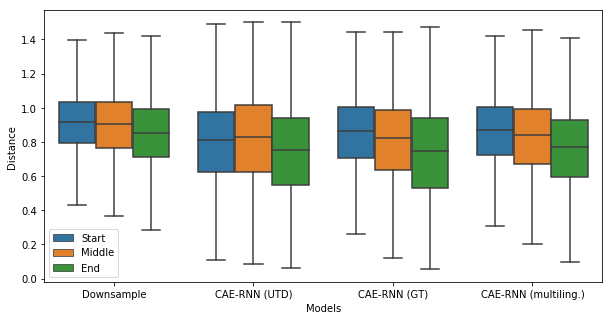

In [149]:
# Box plot
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(data=df_edit_positions, ax=ax, x="model", y="distance", hue="position", order=models, hue_order=["start", "middle", "end"], showfliers=False)
ax.set_xticklabels(model_titles)
handles, lables = ax.get_legend_handles_labels()
ax.legend(handles, ["Start", "Middle", "End"], loc="lower left")
ax.set_xticklabels(model_titles)
plt.xlabel("Models")
plt.ylabel("Distance")
plt.savefig(path.join("doc", language.lower() + ".edit_positions_boxplot.pdf"))